# Fundamental Analysis
This notebook plots various fundamental statistics of different stocks.  
These links were helpful:  
https://simply-python.com/2015/02/13/getting-historical-financial-statistics-of-stock-using-python/  
http://stackoverflow.com/questions/40139537/scrape-yahoo-finance-financial-ratios  
https://automatetheboringstuff.com/chapter11/  
http://docs.python-guide.org/en/latest/scenarios/scrape/  

## Todo
- See the Learning curve, to determine if I'm limited by my sample size...
- Check classification instead of regression as well - will the stock go up or down? Looks imbalanced set though...
- Maybe try predicting only 6 months in advance instead of a year.
- Have time information for featuers, i.e. EPS_i+1 / EPS_i for a given stock

In [1]:
import pandas as pd
import numpy as np
import requests
import sys
import matplotlib.pyplot as plt
from pandas_datareader.data import DataReader
from pandas.tseries.offsets import BMonthEnd
from pattern.web import URL
%matplotlib inline

## Choose Sector to analyze
- Important to analyze stocks from the same sector, as different sectors have different standards. E.g. a typical Debt/Equity ratio of one sector can be very different from another sector.  
- Download stock lists from http://www.nasdaq.com/screening/industries.aspx  

In [2]:
#tickers = pd.read_csv('csv/s&p500.csv',delimiter=",")
tickers = pd.read_csv('csv/wilshire5000.csv',delimiter=",")

#industry = 'Finance'
#tickers = pd.read_csv('csv/nasdaq/%s.csv'%industry,delimiter=",")
#tickers = tickers.loc[stocks['MarketCap']>1e7]  #exclude stocks with small market cap

tickers.head()

,Symbol,Company
0,A,Agilent Technologies
1,AA,Alcoa Inc
2,AACC,Asset Accep Cap Corp
3,AAI,Airtran Hldgs Inc
4,AAII,Alabama Aircraft Ind In


## Get Data

In [44]:
#scrape financial data from Morningstar
def get_stock_financials(stock,year):
    #pre-load stuff
    path = "Fundamental_Analysis/"
    skiprows = [19,20,31,41,42,43,48,58,53,64,65,72,73,95,101,102]
    del_if_present = ['AUD','EUR','BRL','CAD','ARS','CHF','CLP','CNY','COP','GBP','ILS','INR','JPY','KRW','MXN','PEN','PLN','RON','RUB','SEK','THB','TWD','ZAR']
    del_columns = ['Year over Year','3-Year Average','5-Year Average','10-Year Average','Taxes Payable','Long-Term Debt']
    #scrape/load data
    try:
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    except:
        webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
        url = URL(webpage)
        f = open('%s%s_keyratios.csv'%(path, stock), 'wb') #save key ratios
        f.write(url.download())
        f.close()
        d = pd.read_csv('%s%s_keyratios.csv'%(path, stock), header=2, index_col=0, skiprows=skiprows)
    d = d.transpose().reset_index()
    #delete annoying repeated columns, ignore if non-US stocks for consistency
    for dip in del_if_present:
        if np.any(d.columns.str.contains(dip)):            #delete if present
            return pd.DataFrame(columns=d.columns)         #return empty dataframe so that this entry will be ignored
    d = d.dropna(axis='columns', how='all')
    for dc in del_columns: 
        try:
            del d[dc]
        except:
            pass
    #isolate desired year
    d = d[d['index'].str.contains("%d"%year)] 
    #final additions
    d.insert(0,'Stock',stock)                              #keep stock ticker
    date = last_weekday_of_month(d['index'].values[0])
    d.insert(1,'Price',DataReader(stock,'yahoo',date,date)['Adj Close'].values[0]) #get stock price
    return d

#small helper function for getting target
def last_weekday_of_month(date):
    return pd.date_range(date, periods=1, freq='BM')

#scrapes data from yahoo, gets target
def get_frac_price_change(stock,date,true_threshold):
    last_current = last_weekday_of_month(date)
    ds = date.split('-')
    last_future = last_weekday_of_month('%d-%s'%(int(ds[0])+1, ds[1]))
    current_price = DataReader(stock, 'yahoo', last_current, last_current)['Adj Close'].values[0]
    future_price = DataReader(stock, 'yahoo', last_future, last_future)['Adj Close'].values[0]
    fractional_change = future_price/current_price
    if fractional_change > true_threshold:
        return 1, fractional_change
    else:
        return 0, fractional_change
    
#simple progress bar
def progress(sequence, every=10):
    length = float(len(sequence))
    for index, item in enumerate(sequence):
        if index % every == 0:
            print >>sys.stderr, index/length,
        yield item
    
#Top-level function which acquires all the data
def get_data(ticker_csv,year,true_threshold):
    ticker_loc = ticker_csv.split(".csv")[0]
    try:
        X = pd.read_csv("%s_%d_X.csv"%(ticker_loc,year))
        ychange = np.loadtxt("%s_%d_ychange.csv"%(ticker_loc,year), delimiter=",")
        skip = np.loadtxt("%s_%d_skip.csv"%(ticker_loc,year), dtype="str",delimiter=",")
        y = np.zeros(ychange.shape[0])
        y[ychange > true_threshold] = 1
        print "Loaded data from csv's..."
    except:
        print "Couldn't find csvs, scraping data from Morningstar..."
        #create empty dataframe with available columns
        stocks = pd.read_csv(ticker_csv,delimiter=",")
        cols = get_stock_financials(stocks["Symbol"][0],year).columns
        X = pd.DataFrame(columns=cols)
        y = []
        ychange = []
        skip = []
        for s in progress(stocks["Symbol"], len(stocks["Symbol"])/10):
            try:
                _X = get_stock_financials(s,year)
                _y, _ychange = get_frac_price_change(s,_X['index'].values[0],true_threshold)
                if _X.shape[1] > 1 and np.isfinite(_y): #only append if alg actually recovered data
                    X = X.append(_X)
                    y.append(_y)
                    ychange.append(_ychange)
            except:
                skip.append(s)
        X = X.set_index('Stock')
        X = X.convert_objects(convert_numeric=True)     #X = pd.to_numeric(X)
        #save to csv for ease of loading next time
        y, ychange, skip = np.asarray(y), np.asarray(ychange), np.asarray(skip)
        X.to_csv("%s_%d_X.csv"%(ticker_loc,year))
        np.savetxt("%s_%d_ychange.csv"%(ticker_loc,year), ychange, delimiter=",")
        np.savetxt("%s_%d_skip.csv"%(ticker_loc,year), skip, fmt="%s", delimiter=",")
    return X, y, ychange, skip

Load the data below. This could take a minute.  
- true_threshold = fractional change in price ($S_{i+1}/S_i$) for classifying stock as True (i.e. 1). Otherwise False (i.e. 0). 

In [100]:
year = 2015
true_threshold=1.0 
ticker_csv = "csv/wilshire5000.csv"

X, y, ychange, skip = get_data(ticker_csv, year, true_threshold)

Loaded data from csv's...


In [101]:
#X['Debt/Equity'] = pd.to_numeric(X['Debt/Equity'])
#X = X.convert_objects(convert_numeric=True)

## Engineer Features and Process Data
Grab columns of interest to be used, replace NaN values, get training/test sets.

In [102]:
#delete columns with >10% NaN values...
#...for remaining columns, replace NaN values with median
for c in X.columns:
    frac_NaN = X[c].isnull().sum()/float(len(X))
    if frac_NaN > 0.1:
        del X[c]
        print "**Deleted** %s: NaN fraction = %.4f"%(c, frac_NaN)
    else:
        try:
            X[c] = pd.to_numeric(X[c])
            X[c].fillna(X[c].median(), inplace=True)
            print "%s: NaN fraction = %.4f"%(c, frac_NaN)
        except:
            print "couldnt convert %s column to numeric. NaN fraction=%.4f"%(c, frac_NaN)

couldnt convert Stock column to numeric. NaN fraction=0.0000
**Deleted** Accounts Payable: NaN fraction = 0.2055
Accounts Receivable: NaN fraction = 0.0656
**Deleted** Accrued Liabilities: NaN fraction = 0.1655
Asset Turnover: NaN fraction = 0.0204
Asset Turnover (Average): NaN fraction = 0.0204
Book Value Per Share * USD: NaN fraction = 0.0082
**Deleted** COGS: NaN fraction = 0.2087
Cap Ex as a % of Sales: NaN fraction = 0.0506
**Deleted** Cap Spending USD Mil: NaN fraction = 0.1105
Cash & Short-Term Investments: NaN fraction = 0.0053
**Deleted** Cash Conversion Cycle: NaN fraction = 0.4142
**Deleted** Current Ratio: NaN fraction = 0.1553
**Deleted** Days Inventory: NaN fraction = 0.3926
**Deleted** Days Sales Outstanding: NaN fraction = 0.1957
**Deleted** Debt/Equity: NaN fraction = 0.2605
**Deleted** Dividends USD: NaN fraction = 0.4509
EBT Margin: NaN fraction = 0.0269
Earnings Per Share USD: NaN fraction = 0.0057
Financial Leverage: NaN fraction = 0.0554
Financial Leverage (Averag

In [103]:
X.columns

Index([u'Stock', u'Accounts Receivable', u'Asset Turnover',
       u'Asset Turnover (Average)', u'Book Value Per Share * USD',
       u'Cap Ex as a % of Sales', u'Cash & Short-Term Investments',
       u'EBT Margin', u'Earnings Per Share USD', u'Financial Leverage',
       u'Financial Leverage (Average)', u'Fixed Assets Turnover',
       u'Free Cash Flow Per Share * USD', u'Free Cash Flow/Net Income',
       u'Free Cash Flow/Sales %', u'Net Income USD Mil',
       u'Net Int Inc & Other', u'Net Margin %', u'Net PP&E',
       u'Operating Margin', u'Operating Margin %', u'Price',
       u'Return on Assets %', u'Return on Equity %', u'Revenue', u'SG&A',
       u'Shares Mil', u'Total Assets', u'Total Liabilities',
       u'Total Liabilities & Equity', u'Total Stockholders' Equity', u'index'],
      dtype='object')

Feature Engineering:
- Working Capital Ratio - how easily that company can turn assets into cash to pay short-term obligations
- Price/Earnings Ratio - investors' assessment of future earnings
- Price/Book Ratio
- Debt/Equity Ratio

In [104]:
#feature engineering
X['Working Capital Ratio'] = X['Total Assets']/X['Total Liabilities']   
X['P/E Ratio'] = X['Price']/X['Earnings Per Share USD']                 
X['P/B Ratio'] = X['Price']/X['Book Value Per Share * USD']
X['D/E Ratio'] = X['Total Liabilities']/X["Total Stockholders' Equity"] 

#features to include for analysis
percentiles = ['Net Margin %','Return on Equity %','Return on Assets %','Operating Margin %','Free Cash Flow/Sales %', 'Cap Ex as a % of Sales']
ratios = ['Book Value Per Share * USD', 'Earnings Per Share USD','Free Cash Flow Per Share * USD','EBT Margin',
          'Working Capital Ratio','P/E Ratio','P/B Ratio', 'D/E Ratio', 'Asset Turnover', 'Financial Leverage']

features = percentiles + ratios

In [105]:
XX = X[features]

In [106]:
XX.head()

,Net Margin %,Return on Equity %,Return on Assets %,Operating Margin %,Free Cash Flow/Sales %,Cap Ex as a % of Sales,Book Value Per Share * USD,Earnings Per Share USD,Free Cash Flow Per Share * USD,EBT Margin,Working Capital Ratio,P/E Ratio,P/B Ratio,D/E Ratio,Asset Turnover,Financial Leverage
0,9.93,8.47,4.38,12.9,9.73,2.43,12.36,1.20,0.90,11.89,2.258356,31.040855,3.013675,0.794688,0.44,1.79
1,2.40,3.86,1.26,3.4,1.14,0.19,5.05,0.19,0.21,3.44,1.483239,26.155963,0.984086,2.069368,0.53,3.07
2,4.27,10.48,5.31,7.4,3.34,1.90,18.50,1.86,1.72,6.70,2.057613,11.990263,1.205508,0.945525,1.24,1.95
3,12.75,25.91,19.63,19.9,8.91,5.85,3.74,0.84,0.62,19.89,4.317789,27.532204,6.183703,0.301406,1.54,1.30
4,4.84,21.14,5.86,8.5,4.67,2.41,32.94,6.40,6.26,7.73,1.433692,23.481358,4.562255,2.305785,1.21,3.31


In [107]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(XX, y, test_size=0.25, random_state=42)

## Machine Learning tyme
Do an initial search with a high learning rate and few n_estimators, then do a second tune with lower learning rate and many more estimators.  

In [108]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
xgb.XGBClassifier()

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [111]:
#scale classes based on relative imbalance
scale_pos_weight = len(y_train[y_train==0])/float(len(y_train[y_train==1]))
scale_pos_weight

0.4322429906542056

In [70]:
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
n_cv = 5
n_iter = 10     #number of RandomizedSearchCV search iterations
param_grid={
    'learning_rate': [0.1],
    'max_depth': [2,4,8,16],
    'min_child_weight': [0.1,0.5,1,3],
    'colsample_bytree': [0.5,1],
    'gamma': [0,0.2,0.4],
    'n_estimators':[1000],
}

grid = RandomizedSearchCV(model, param_distributions=param_grid, n_iter=n_iter, cv=n_cv, scoring='roc_auc')
grid.fit(X_train,y_train)

print(grid.best_score_)
print(grid.best_params_)

0.650044452255
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'min_child_weight': 1, 'n_estimators': 1000, 'max_depth': 2, 'gamma': 0}


In [112]:
#Do final train with best parameters, lower learning rate and more estimators
model = xgb.XGBClassifier(scale_pos_weight=scale_pos_weight)
best_params={
    'learning_rate': [5e-3],
    'n_estimators':[3000],
    'max_depth': [2],
    'min_child_weight': [1],
    'colsample_bytree': [0.5],
    'gamma': [0],
}
final_model = GridSearchCV(model, param_grid=best_params, cv=n_cv, scoring='roc_auc')
final_model.fit(X_train,y_train)

#best model
xgb_model = final_model.best_estimator_
print(final_model.best_score_)

0.68610636574


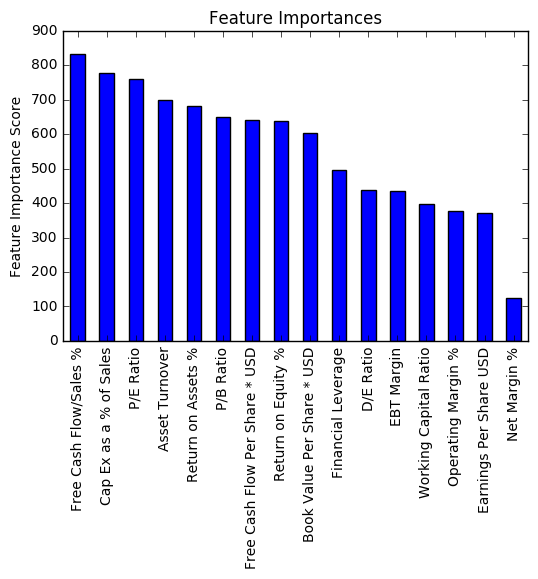

In [113]:
#seems equivalent to model.feature_importances_
feat_imp = pd.Series(xgb_model.booster().get_fscore()).sort_values(ascending=False) 
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')

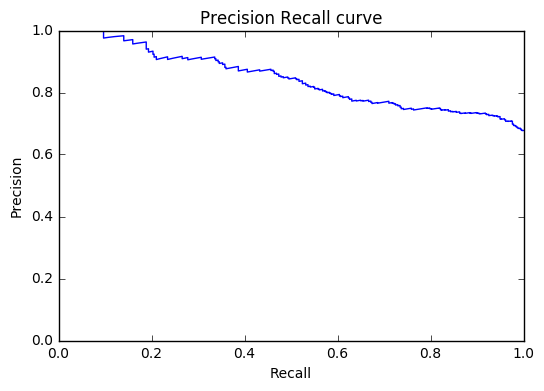

In [114]:
from sklearn.metrics import precision_recall_curve
y_pred = xgb_model.predict_proba(X_test)
precision, recall, thresholds = precision_recall_curve(y_test, y_pred[:,1])
fig, ax = plt.subplots()
ax.plot(recall, precision)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.0])
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_title('Precision Recall curve')

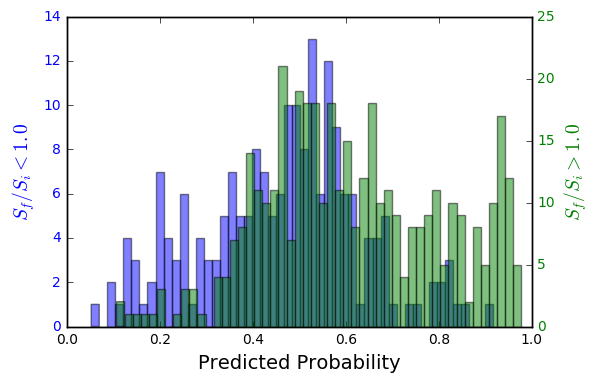

In [116]:
# Histogram to see class predictions
bins = 50
y_pred=xgb_model.predict_proba(X_test)
True_Class=y_pred[y_test==1][:,1]
False_Class=y_pred[y_test==0][:,1]

fig, ax1 = plt.subplots()
ax1.hist(False_Class, bins, alpha=0.5, label='No', color='blue')
ax1.set_xlabel('Predicted Probability', fontsize=14)
ax1.set_ylabel('$S_f/S_i<%.1f$'%true_threshold,  fontsize=14, color='blue')
for tl in ax1.get_yticklabels():
    tl.set_color('blue')
    
ax2 = ax1.twinx()
ax2.hist(True_Class, bins, alpha=0.5, label='Yes',color='green')
ax2.set_ylabel('$S_f/S_i>%.1f$'%true_threshold, fontsize=14, color='green')
for tl in ax2.get_yticklabels():
    tl.set_color('green')

# Extra

In [ ]:
# param_grid={
#     'learning_rate': [0.01],
#     'max_depth': [4],
#     'min_child_weight': [0.1],
#     'n_estimators':[2000],
# }
#grid = GridSearchCV(model, param_grid=param_grid, cv=n_cv, scoring='neg_mean_squared_error')

In [38]:
#s = "AA"
#data = get_stock_financials(s,2014)
#start = data['index'].values[0]
#get_frac_price_change(s,start)

#a= get_stock_price_change("ACN",start)
#print a

In [33]:
#This is useful scraping code for extracting the sector that each stock is from...
#http://docs.python-guide.org/en/latest/scenarios/scrape/
from lxml import html
import requests
def get_sectors(df,path):
    sectors = ['financials', 'healthcare', 'energy', 'basic-materials', 'industrials', 
           'technology', 'telecoms', 'utilities', 'non-cyclicals']
    df['Sector'] = ''
    DNF = []
    for i,st in enumerate(df['Ticker']):
        url = "http://www.reuters.com/finance/stocks/overview?symbol=%s"%st
        page = requests.get(url)
        tree = html.fromstring(page.content)
        found_sector = 0
        for sec in sectors:
            if len(tree.xpath('//a[@href="/sectors/%s"]/text()'%sec)) > 0:
                df["Sector"].iloc[i] = sec
                found_sector = 1
        if found_sector == 0:
            DNF.append(st)
            #print 'couldnt find sector for %s'%st
    df.to_csv(path)
    print "%f stocks did not have a sector found"%float(len(DNF))/float(len(df['Ticker']))
    return df, DNF

In [32]:
df, dnf = get_sectors(tickers,'csv/wilshire5000_sectors.csv')

In [24]:
stock = "AEM"
webpage = "http://financials.morningstar.com/ajax/exportKR2CSV.html?t=%s&culture=en-CA&region=USA&order=asc&r=314562"%stock
url = URL(webpage)
f = open('Fundamental_Analysis/%s_keyratios.csv'%stock, 'wb') # save as test.gif
f.write(url.download())
f.close()